#### regarding bigWig -> still have to double check what is the "sum" metadata that it reports -> sum of individual counts, or "integral" over the counts along the genome ...

In [112]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [113]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [147]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
# # assortment of relevant BED files with the features of interest ...
# feature_of_interest = "rad21_merged.bed"
# feature_of_interest = "G4-Mao-sort"
feature_of_interest = "NT-CTCF-narrowPeaks-sort-merge-noTSS"

# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp allTSS.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [116]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end"]
)
df = df.sort_values(["chrom","start"])
df = df[df["chrom"].isin(autosomal_chroms)]
df = df.reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


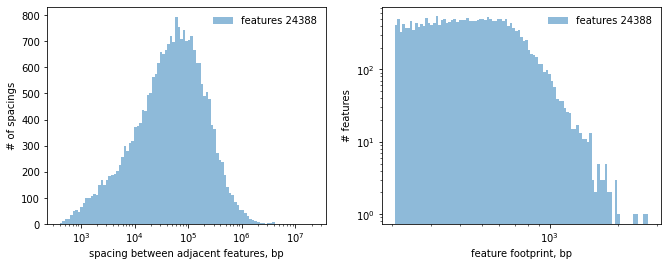

In [117]:
# calculate "spacing" between adjacent features,
# assuming coordinates are sorted !
plot_spacing_footprint_distros({k:df for k in ['features']})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

number of candidate features before and after merging: 24388 -> 24388


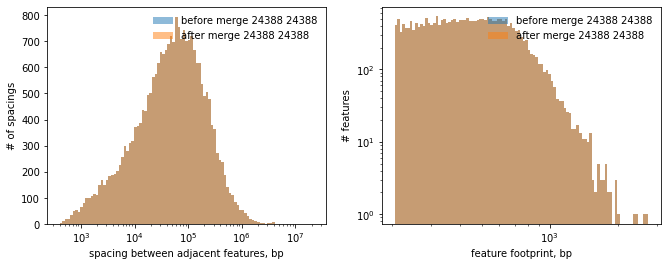

In [118]:
merge_radius = 100
df_merged = bf.merge(df, min_dist=merge_radius)

plot_spacing_footprint_distros({
    f"before merge {len(df)}":df,
    f"after merge {len(df_merged)}":df_merged,
})

print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [119]:
#let's describe our samples that we want to have in Figure 1 ...
# "ddx_CTCF","ddx_noCTCF"
plot_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","ddx_CTCF","ddx_noCTCF",'taf5l_CTCF','taf5l_noCTCF','h3k4_r1',"mrna_ctcf",'input_CTCF','input_noCTCF']

titles = plot_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in plot_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [120]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan  )

stacking up ctcf ...
CPU times: user 3.85 s, sys: 240 ms, total: 4.09 s
Wall time: 4.1 s
stacking up noctcf ...
CPU times: user 3.5 s, sys: 201 ms, total: 3.7 s
Wall time: 3.72 s
stacking up rad21_CTCF ...
CPU times: user 3.94 s, sys: 289 ms, total: 4.23 s
Wall time: 4.45 s
stacking up rad21_noCTCF ...
CPU times: user 3.06 s, sys: 348 ms, total: 3.41 s
Wall time: 3.48 s
stacking up ins_CTCF ...
CPU times: user 2.78 s, sys: 164 ms, total: 2.94 s
Wall time: 2.95 s
stacking up ins_noCTCF ...
CPU times: user 2.82 s, sys: 156 ms, total: 2.98 s
Wall time: 2.99 s
stacking up ddx_CTCF ...
CPU times: user 3.86 s, sys: 269 ms, total: 4.13 s
Wall time: 4.23 s
stacking up ddx_noCTCF ...
CPU times: user 3.65 s, sys: 173 ms, total: 3.82 s
Wall time: 3.85 s
stacking up taf5l_CTCF ...
CPU times: user 3.98 s, sys: 222 ms, total: 4.2 s
Wall time: 4.43 s
stacking up taf5l_noCTCF ...
CPU times: user 3.72 s, sys: 241 ms, total: 3.97 s
Wall time: 4.14 s
stacking up h3k4_r1 ...
CPU times: user 4.71 s, sys: 1

In [121]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
aaa = rstacks(
    "pcgene_plus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
bbb = rstacks(
    "pcgene_minus.bb",
    df,
    flank=annot_flank,
    binsize=annot_binsize,
)
stackups[feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
plot_samples.append(feat_name)
titles = plot_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [122]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
normalize_insulation_stackups_INPLACE(
    stackups_set = stackups,
    ins_keys = insulation_keys
)

# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

### it's amazing how much you can do with a stack up !

we can flip certain rows !

_beware_ that we are reordering index this way, and we also might loos some rows from a stackup because of NaNs

In [123]:
length, width = stackups['ctcf'].shape
center_bin = int(width/2)

stackups['rad21_iaa_mean'] = np.nanmean(stackups['rad21_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
stackups['ddx_iaa_mean'] = np.nanmean(stackups['ddx_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
stackups['taf_iaa_mean'] = np.nanmean(stackups['taf5l_noCTCF'][:,center_bin-2:center_bin+2],axis=1)
stackups['input_iaa_mean'] = np.nanmean(stackups['input_noCTCF'][:,center_bin-2:center_bin+2],axis=1)

stackups['rad21_mean'] = np.nanmean(stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
stackups['ctcf_mean'] = np.nanmean(stackups['ctcf'][:,center_bin-2:center_bin+2],axis=1)
stackups['ddx_mean'] = np.nanmean(stackups['ddx_CTCF'][:,center_bin-2:center_bin+2],axis=1)
stackups['taf_mean'] = np.nanmean(stackups['taf5l_CTCF'][:,center_bin-2:center_bin+2],axis=1)
stackups['input_mean'] = np.nanmean(stackups['input_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    
initial_index = np.arange( len(stackups['ctcf_mean']) )
ks = [('ctcf_mean', "sort", 1, False)]
_, jjj = recursive_data_ordering( ks, initial_index, stackups, verbose=True)


sorting 24388 elements of ctcf_mean into 1 groups ...


In [124]:
dat_nt = pd.DataFrame({"X":stackups['rad21_mean'],"Y1":stackups['ddx_mean'],"Y2":stackups['taf_mean'],"Y3":stackups['input_mean']})
dat_iaa = pd.DataFrame({"X":stackups['rad21_iaa_mean'],"Y1":stackups['ddx_iaa_mean'],"Y2":stackups['taf_iaa_mean'],"Y3":stackups['input_iaa_mean']})
    
dat_nt = dat_nt.reset_index(drop=True)
dat_iaa = dat_iaa.reset_index(drop=True)
dat_iaa["type"]="iaa"
dat_nt["type"]="nt"
# dat = pd.concat([dat_nt,dat_iaa]).reset_index(drop=True)
dat = pd.concat([dat_iaa,dat_nt]).reset_index(drop=True)

In [125]:
import datashader as ds
import matplotlib.pyplot as plt
from datashader.mpl_ext import dsshow, alpha_colormap
import datashader.transfer_functions as tf
from functools import partial
from scipy.stats import linregress

Text(0, 0.5, 'Input')

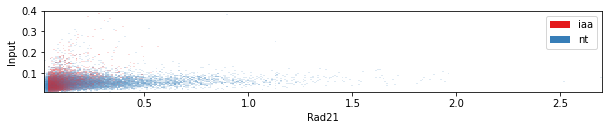

In [128]:
_dat_iaa = dat_iaa.dropna()[(dat_iaa.dropna()["X"]<5)&(dat_iaa.dropna()["Y3"]<0.5)]
_dat_nt = dat_nt.dropna()[(dat_nt.dropna()["X"]<5)&(dat_nt.dropna()["Y3"]<0.5)]
slope_iaa,intercept_iaa,*_ = linregress(_dat_iaa.dropna()["X"].values,_dat_iaa.dropna()["Y3"].values)
slope_nt,intercept_nt,*_ = linregress(_dat_nt.dropna()["X"].values,_dat_nt.dropna()["Y3"].values)
slope_iaa,slope_nt,intercept_iaa,intercept_nt

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

da2 = dsshow(
       dat.transform({'X':lambda x:np.clip(x,0,2.7),'Y3':lambda y:np.clip(y,0,0.4),"type":lambda z:z.astype("category")}),
       ds.Point('X', 'Y3'),
       ds.count_cat('type'),
        plot_width=300,
        plot_height=100,
#        shade_hook=partial(tf.dynspread, threshold=0.5,shape="circle", how='over'),
       ax=ax)
# ax.set_title(_title)
plt.legend(handles=da2.get_legend_elements());

# _l_iaa = lambda x: slope_iaa*x + intercept_iaa
# _l_nt = lambda x: slope_nt*x + intercept_nt
# ax.plot([0,4],[_l_iaa(0),_l_iaa(4)],color="red")
# ax.plot([0,4],[_l_nt(0),_l_nt(4)],color="blue")
ax.set_xlabel("Rad21")
ax.set_ylabel("Input")

Text(0, 0.5, 'DDX55')

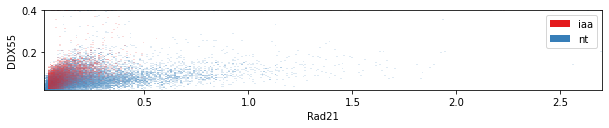

In [126]:
_dat_iaa = dat_iaa.dropna()[(dat_iaa.dropna()["X"]<5)&(dat_iaa.dropna()["Y1"]<0.5)]
_dat_nt = dat_nt.dropna()[(dat_nt.dropna()["X"]<5)&(dat_nt.dropna()["Y1"]<0.5)]
slope_iaa,intercept_iaa,*_ = linregress(_dat_iaa.dropna()["X"].values,_dat_iaa.dropna()["Y1"].values)
slope_nt,intercept_nt,*_ = linregress(_dat_nt.dropna()["X"].values,_dat_nt.dropna()["Y1"].values)
slope_iaa,slope_nt,intercept_iaa,intercept_nt

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

da2 = dsshow(
       dat.transform({'X':lambda x:np.clip(x,0,2.7),'Y1':lambda y:np.clip(y,0,0.4),"type":lambda z:z.astype("category")}),
       ds.Point('X', 'Y1'),
       ds.count_cat('type'),
        plot_width=300,
        plot_height=100,
#        shade_hook=partial(tf.dynspread, threshold=0.5,shape="circle", how='over'),
       ax=ax)
# ax.set_title(_title)
plt.legend(handles=da2.get_legend_elements());

# _l_iaa = lambda x: slope_iaa*x + intercept_iaa
# _l_nt = lambda x: slope_nt*x + intercept_nt
# ax.plot([0,4],[_l_iaa(0),_l_iaa(4)],color="red")
# ax.plot([0,4],[_l_nt(0),_l_nt(4)],color="blue")
ax.set_xlabel("Rad21")
ax.set_ylabel("DDX55")

Text(0, 0.5, 'TAF5L')

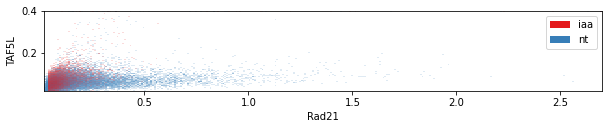

In [127]:
_dat_iaa = dat_iaa.dropna()[(dat_iaa.dropna()["X"]<5)&(dat_iaa.dropna()["Y2"]<0.5)]
_dat_nt = dat_nt.dropna()[(dat_nt.dropna()["X"]<5)&(dat_nt.dropna()["Y2"]<0.5)]
slope_iaa,intercept_iaa,*_ = linregress(_dat_iaa.dropna()["X"].values,_dat_iaa.dropna()["Y2"].values)
slope_nt,intercept_nt,*_ = linregress(_dat_nt.dropna()["X"].values,_dat_nt.dropna()["Y2"].values)
slope_iaa,slope_nt,intercept_iaa,intercept_nt

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

da2 = dsshow(
       dat.transform({'X':lambda x:np.clip(x,0,2.7),'Y2':lambda y:np.clip(y,0,0.4),"type":lambda z:z.astype("category")}),
       ds.Point('X', 'Y2'),
       ds.count_cat('type'),
        plot_width=300,
        plot_height=100,
#        shade_hook=partial(tf.dynspread, threshold=0.5,shape="circle", how='over'),
       ax=ax)
# ax.set_title(_title)
plt.legend(handles=da2.get_legend_elements());

# _l_iaa = lambda x: slope_iaa*x + intercept_iaa
# _l_nt = lambda x: slope_nt*x + intercept_nt
# ax.plot([0,4],[_l_iaa(0),_l_iaa(4)],color="red")
# ax.plot([0,4],[_l_nt(0),_l_nt(4)],color="blue")
ax.set_xlabel("Rad21")
ax.set_ylabel("TAF5L")

Text(0, 0.5, 'TAF5L')

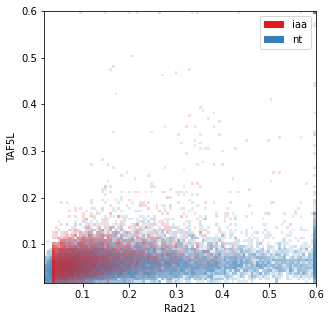

In [86]:
_dat_iaa = dat_iaa.dropna()[(dat_iaa.dropna()["X"]<0.5)&(dat_iaa.dropna()["Y2"]<0.5)]
_dat_nt = dat_nt.dropna()[(dat_nt.dropna()["X"]<0.5)&(dat_nt.dropna()["Y2"]<0.5)]
slope_iaa,intercept_iaa,*_ = linregress(_dat_iaa.dropna()["X"].values,_dat_iaa.dropna()["Y2"].values)
slope_nt,intercept_nt,*_ = linregress(_dat_nt.dropna()["X"].values,_dat_nt.dropna()["Y2"].values)
slope_iaa,slope_nt,intercept_iaa,intercept_nt

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

da2 = dsshow(
       dat.transform({'X':lambda x:np.clip(x,0,.6),'Y2':lambda y:np.clip(y,0,.6),"type":lambda z:z.astype("category")}),
       ds.Point('X', 'Y2'),
       ds.count_cat('type'),
        plot_width=100,
        plot_height=100,
#        shade_hook=partial(tf.dynspread, threshold=0.5,shape="circle", how='over'),
       ax=ax)
# ax.set_title(_title)
plt.legend(handles=da2.get_legend_elements());

# _l_iaa = lambda x: slope_iaa*x + intercept_iaa
# _l_nt = lambda x: slope_nt*x + intercept_nt
# ax.plot([0,0.4],[_l_iaa(0),_l_iaa(0.4)],color="red")
# ax.plot([0,0.4],[_l_nt(0),_l_nt(0.4)],color="blue")
ax.set_xlabel("Rad21")
ax.set_ylabel("TAF5L")

<AxesSubplot:xlabel='X', ylabel='Y'>

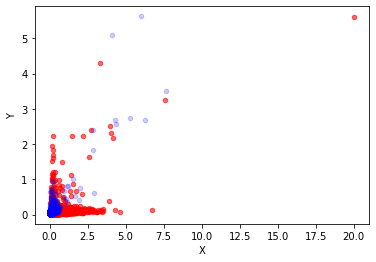

In [74]:
dat1 = pd.DataFrame({"X":stackups['rad21_iaa_mean'],"Y":stackups['ddx_iaa_mean']})
dat2 = pd.DataFrame({"X":stackups['rad21_mean'],"Y":stackups['ddx_mean']})
fig = plt.figure()
ax = fig.add_subplot()
dat2.plot.scatter(x="X",y="Y",ax=ax,color="red",alpha=0.6)
dat1.plot.scatter(x="X",y="Y",ax=ax,color="blue",alpha=0.2)
# dat2.transform({'X':lambda x:np.clip(x,0,1.9),'Y':lambda y:np.clip(y,0,1.9)}).plot.scatter(x="X",y="Y",ax=ax,color="red",alpha=0.6)
# dat1.transform({'X':lambda x:np.clip(x,0,1.8),'Y':lambda y:np.clip(y,0,1.8)}).plot.scatter(x="X",y="Y",ax=ax,color="blue",alpha=0.2)
# dat2.plot.scatter(x="X",y="Y",ax=ax)

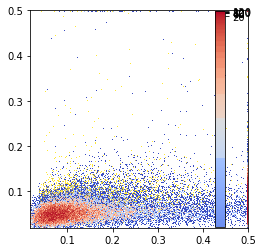

In [69]:
dat1 = pd.DataFrame({"X":stackups['rad21_iaa_mean'],"Y":stackups['ddx_iaa_mean']})
dat2 = pd.DataFrame({"X":stackups['rad21_mean'],"Y":stackups['ddx_mean']})
fig = plt.figure()
ax = fig.add_subplot()
da1 = dsshow(
       dat1.transform({'X':lambda x:np.clip(x,0,0.5),'Y':lambda y:np.clip(y,0,.5)}),
       ds.Point('X', 'Y'),
       # ds.sum("count"),
       norm='eq_hist',
       cmap="cividis_r",
       #aspect=1,
       ax=ax,
       )
da1 = dsshow(
       dat2.transform({'X':lambda x:np.clip(x,0,0.5),'Y':lambda y:np.clip(y,0,.5)}),
       ds.Point('X', 'Y'),
       # ds.sum("count"),
       norm='eq_hist',
       cmap="coolwarm",
       #aspect=1,
       ax=ax,
       )
fig.colorbar(da1,
             ax=ax,
             shrink=0.99,
             pad=-0.1)

In [ ]:
    # example 1
    _da1 = dsshow(
           data,
           ds.Point('X', 'Y'),
           # ds.sum("count"),
           norm='eq_hist',
           cmap="cividis_r",
           #aspect=1,
           ax=ax1)
    fig.colorbar(_da1,
                 ax=ax1,
                 shrink=0.99,
                 pad=-0.1)
    
        # example 2
    _da2 = dsshow(
           data.transform({'X':lambda x:x,'Y':lambda x:x,"tpe": lambda x:x.astype("category")}),
           ds.Point('X', 'Y'),
           ds.count_cat('tpe'),
           ax=ax4)
    _title = ""
    ax4.set_title(_title)
    plt.legend(handles=_da2.get_legend_elements());

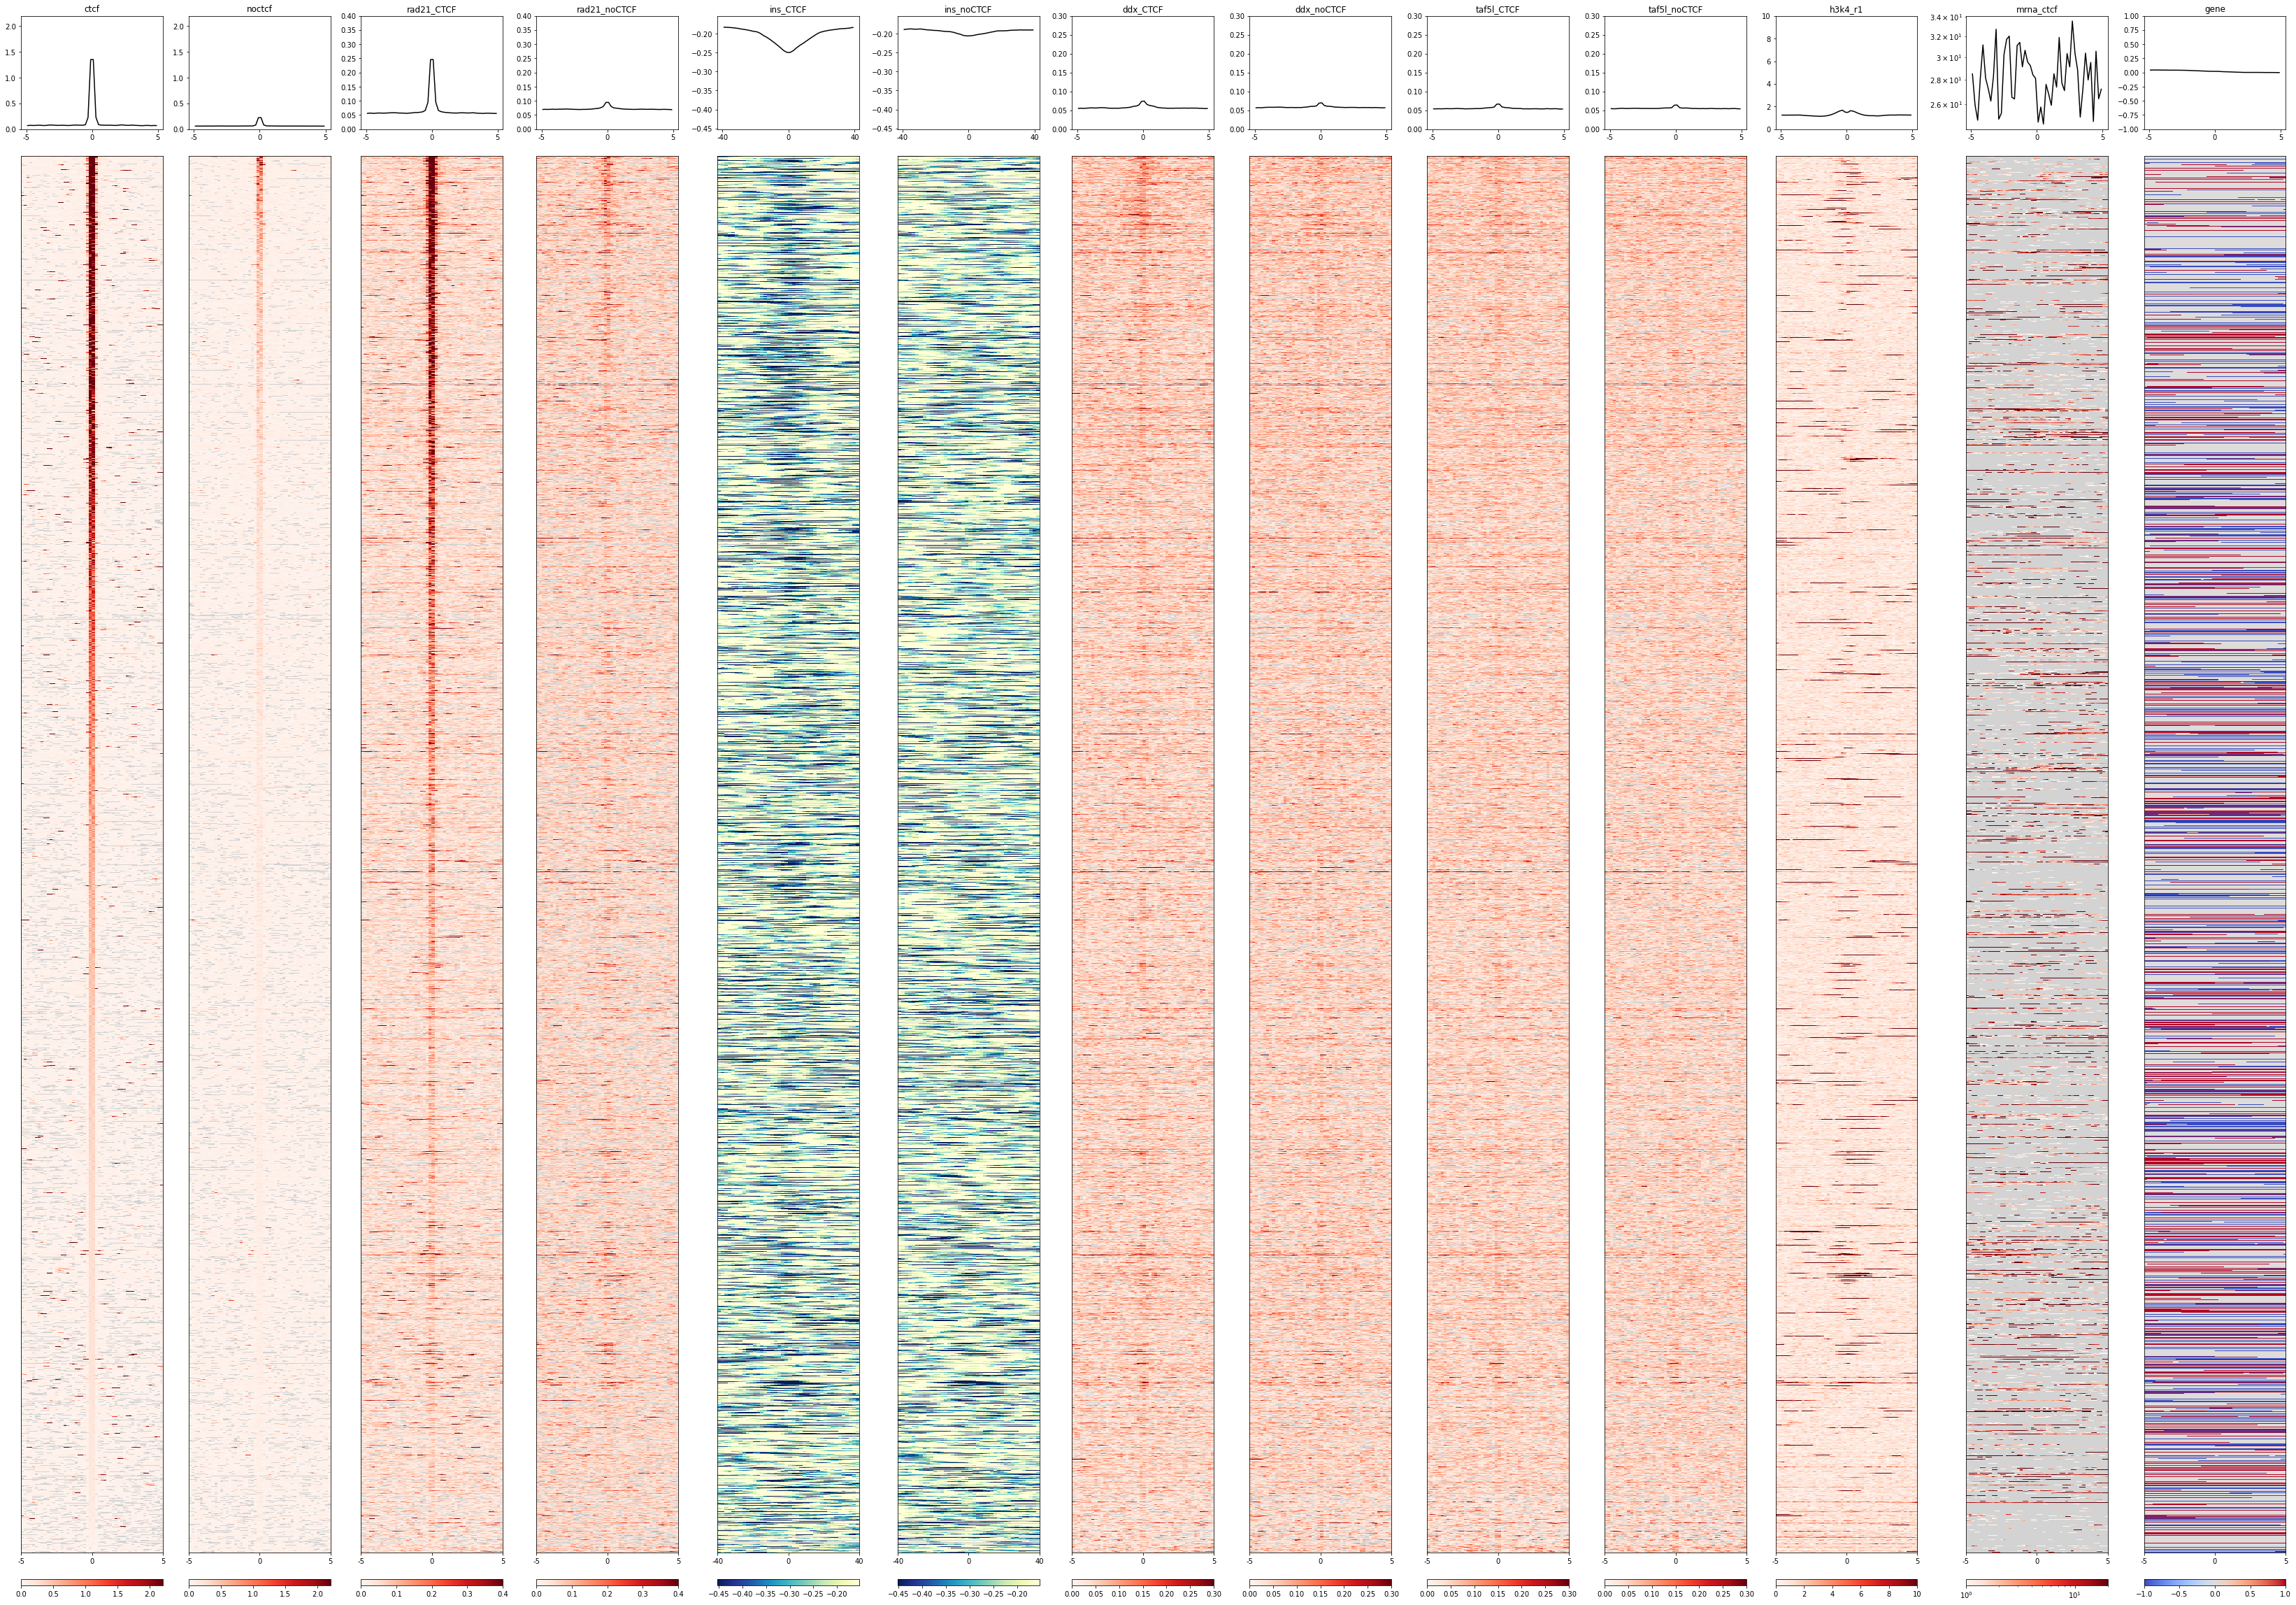

In [16]:
hmss = [ stackups[_k][jjj] for _k in plot_samples ]
_limss = [ limss[_k] for _k in plot_samples ]
_cmps = [ cmps[_k] for _k in plot_samples ]
_binsizes = [ binsizes[_k] for _k in plot_samples ]
_norms = [ norms[_k] for _k in plot_samples ]


# xtra_plots = [1,2]
extra_order = None#[6,7]
hmss_order = None#[-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,12,9,10,11,8,13,14,15]
# assert len(hmss_order) == len(plot_samples)
# xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# # xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group
xtra_axs = plot_stackups(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")


plt.savefig("Fig4-ctcf.pdf")

In [1]:
# !scp Fig4-ctcf.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/